## Importowanie bibliotek i ustawienia

Zaimportuj wszystkie niezbędne biblioteki do analizy danych, wizualizacji, budowy i trenowania modelu LSTM. Ustaw losowość dla powtarzalności wyników.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import yfinance as yf

## Pobieranie i eksploracja danych o cenach Bitcoina

Pobierz dane historyczne Bitcoina (ticker `BTC-USD`) z Yahoo Finance. Wyświetl podstawowe informacje, zakres dat, pierwsze i ostatnie wiersze oraz sprawdź typy danych.

In [2]:
symbol = 'BTC-USD'
data = yf.download(symbol, start='2015-01-01', end=None)
print(f"Liczba wierszy: {len(data)}")
print(f"Zakres dat: {data.index.min().date()} - {data.index.max().date()}")
display(data.head())
display(data.tail())
print(data.dtypes)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Liczba wierszy: 3778
Zakres dat: 2015-01-01 - 2025-05-05


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-05-01,96492.335938,97437.960938,94153.632812,94212.859375,32875889623
2025-05-02,96910.070312,97905.898438,96375.945312,96494.968750,26421924677
2025-05-03,95891.796875,96943.882812,95821.289062,96904.632812,15775154889
2025-05-04,94315.976562,96318.921875,94173.429688,95877.187500,18198688416
2025-05-05,93981.671875,94765.867188,93612.328125,94301.070312,24994191360


Price   Ticker 
Close   BTC-USD    float64
High    BTC-USD    float64
Low     BTC-USD    float64
Open    BTC-USD    float64
Volume  BTC-USD      int64
dtype: object


## Przygotowanie danych do uczenia modelu LSTM

Znormalizuj dane, utwórz sekwencje wejściowe i wyjściowe (np. 14-dniowe okno), podziel dane na zbiory treningowy i testowy oraz dopasuj kształt do wymagań LSTM.

In [ ]:
def create_sequences(series, window_size=14):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(data['Close'].values.reshape(-1, 1)).flatten()

window_size = 14
X, y = create_sequences(scaled_prices, window_size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f'Kształt X_train: {X_train.shape}')
print(f'Kształt y_train: {y_train.shape}')
print(f'Kształt X_test: {X_test.shape}')
print(f'Kształt y_test: {y_test.shape}')

Kształt X_train: (3011, 14, 1)
Kształt y_train: (3011,)
Kształt X_test: (753, 14, 1)
Kształt y_test: (753,)


## Budowa i kompilacja ulepszonego modelu LSTM

Zbuduj model LSTM z kilkoma warstwami, regularizacją (Dropout), BatchNormalization i odpowiednią funkcją aktywacji. Skompiluj model z optymalizatorem Adam i funkcją straty MSE.

In [4]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,785 (120.25 KB)

 Trainable params: 30,593 (119.50 KB)

 Non-trainable params: 192 (768.00 B)

## Trenowanie modelu z zapisem krzywych uczenia

Wytrenuj model z walidacją, zapisz historię uczenia. Zaimplementuj EarlyStopping i/lub ModelCheckpoint. Zwizualizuj krzywe uczenia (loss/val_loss).

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3398 - val_loss: 0.0716
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1032 - val_loss: 0.0663
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0525 - val_loss: 0.0484
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0337 - val_loss: 0.0485
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0236 - val_loss: 0.0301
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0225 - val_loss: 0.0291
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0077
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - val_loss: 0.0031
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 9.9113e-04
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - v

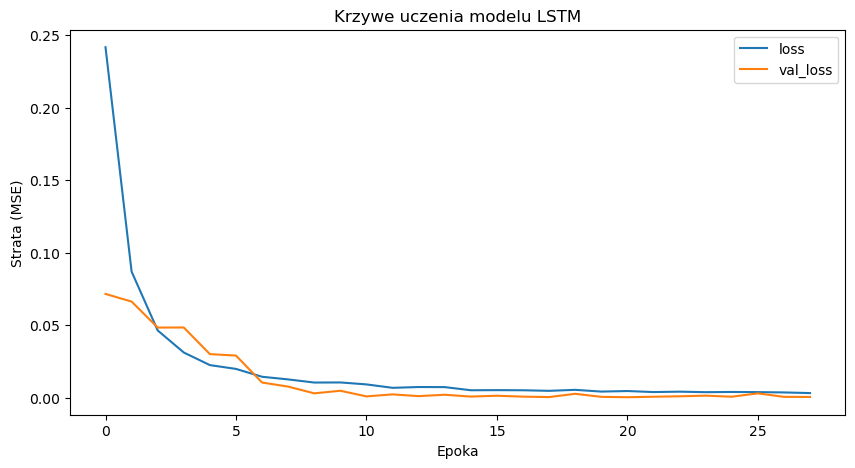

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('best_bitcoin_lstm.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Krzywe uczenia modelu LSTM')
plt.xlabel('Epoka')
plt.ylabel('Strata (MSE)')
plt.legend()
plt.show()

## Ewaluacja modelu na zbiorze testowym

Oceń model na zbiorze testowym, oblicz metryki (MSE, MAE, RMSE, R2). Wyświetl wyniki i zinterpretuj je.

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MSE: 4914354.40
MAE: 1613.21
RMSE: 2216.83
R2: 0.9924


## Wizualizacja rzeczywistych i prognozowanych cen Bitcoina

Przekształć prognozy i rzeczywiste wartości do oryginalnej skali. Narysuj wykres porównujący rzeczywiste i prognozowane ceny na zbiorze testowym.

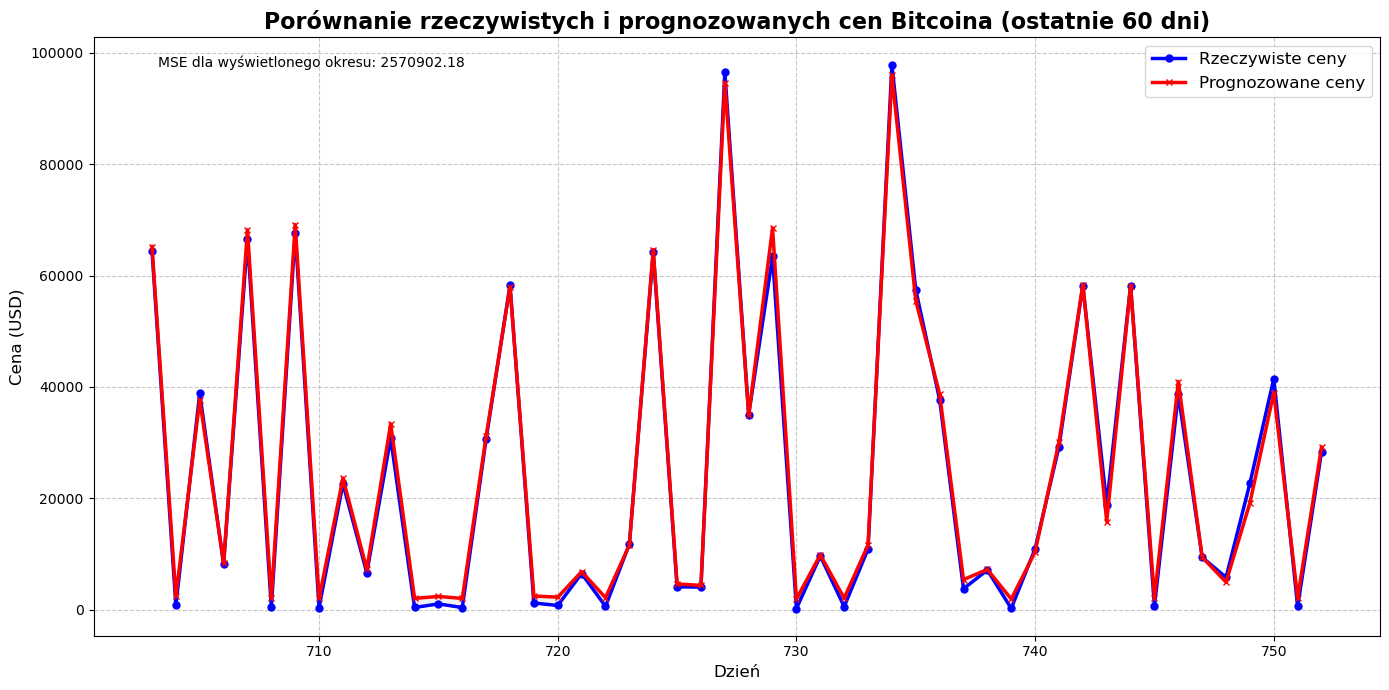

In [10]:
days_to_show = 50
sample_indices = range(len(y_test_inv) - min(days_to_show, len(y_test_inv)), len(y_test_inv))

plt.figure(figsize=(14, 7))
plt.plot(sample_indices, y_test_inv[sample_indices], 
         'b-', linewidth=2.5, label='Rzeczywiste ceny', marker='o', markersize=5)
plt.plot(sample_indices, y_pred_inv[sample_indices], 
         'r-', linewidth=2.5, label='Prognozowane ceny', marker='x', markersize=5)

# Dodanie wypełnienia między liniami dla lepszej wizualizacji różnic
plt.fill_between(sample_indices, y_test_inv[sample_indices], y_pred_inv[sample_indices], 
                 color='lightgray', alpha=0.3)

plt.title('Porównanie rzeczywistych i prognozowanych cen Bitcoina (ostatnie 60 dni)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Dzień', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Dodanie informacji o błędzie dla pokazanego okresu
sample_mse = mean_squared_error(y_test_inv[sample_indices], y_pred_inv[sample_indices])
plt.annotate(f'MSE dla wyświetlonego okresu: {sample_mse:.2f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)

plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

## Prognoza ceny Bitcoina na najbliższy dzień

Wygeneruj prognozę ceny Bitcoina na kolejny dzień na podstawie ostatnich danych. Wyświetl prognozę na wykresie i w formie tekstowej.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\kubal\AppData\Local\Temp\ipykernel_26468\925928524.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_prices = [float(last_days_plot[-2]), float(last_days_plot[-1])]


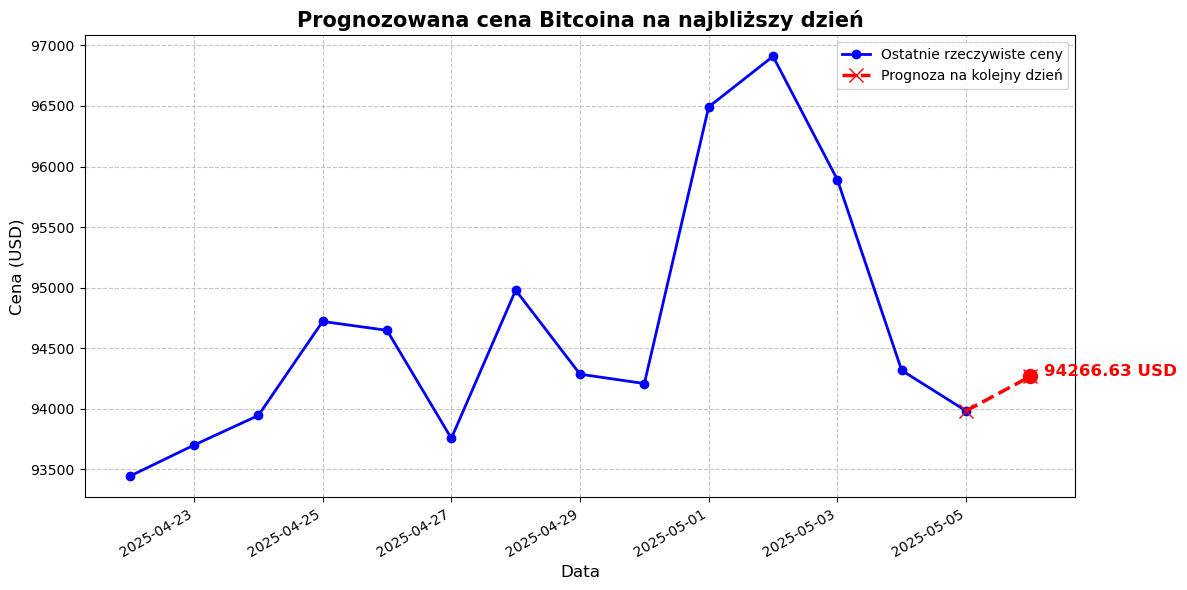

Prognozowana cena Bitcoina na najbliższy dzień: 94266.63 USD


In [11]:
last_days = data['Close'].values[-window_size:]
last_days_scaled = scaler.transform(np.array(last_days).reshape(-1, 1)).flatten()
X_next = np.array(last_days_scaled).reshape(1, window_size, 1)
next_price_scaled = model.predict(X_next)[0][0]
next_price = scaler.inverse_transform([[next_price_scaled]])[0][0]

dates = data.index[-window_size:].tolist()
next_date = dates[-1] + pd.Timedelta(days=1)

last_days_plot = list(last_days)
last_days_plot.append(next_price)
dates_plot = dates + [next_date]

plt.figure(figsize=(12, 6))

plt.plot(dates_plot[:-1], last_days_plot[:-1], 'b-', marker='o', linewidth=2, 
         markersize=6, label='Ostatnie rzeczywiste ceny')

forecast_dates = [dates_plot[-2], dates_plot[-1]]
forecast_prices = [float(last_days_plot[-2]), float(last_days_plot[-1])]
plt.plot(forecast_dates, forecast_prices, 'r--', linewidth=2.5, marker='x', 
         markersize=10, label='Prognoza na kolejny dzień')

plt.scatter(dates_plot[-1], last_days_plot[-1], color='red', s=100, zorder=5)

plt.annotate(f'{next_price:.2f} USD', 
             xy=(dates_plot[-1], last_days_plot[-1]),
             xytext=(10, 0), textcoords='offset points',
             fontsize=12, fontweight='bold', color='red')

plt.title('Prognozowana cena Bitcoina na najbliższy dzień', fontsize=15, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.legend(loc='best')
plt.show()

print(f"Prognozowana cena Bitcoina na najbliższy dzień: {next_price:.2f} USD")

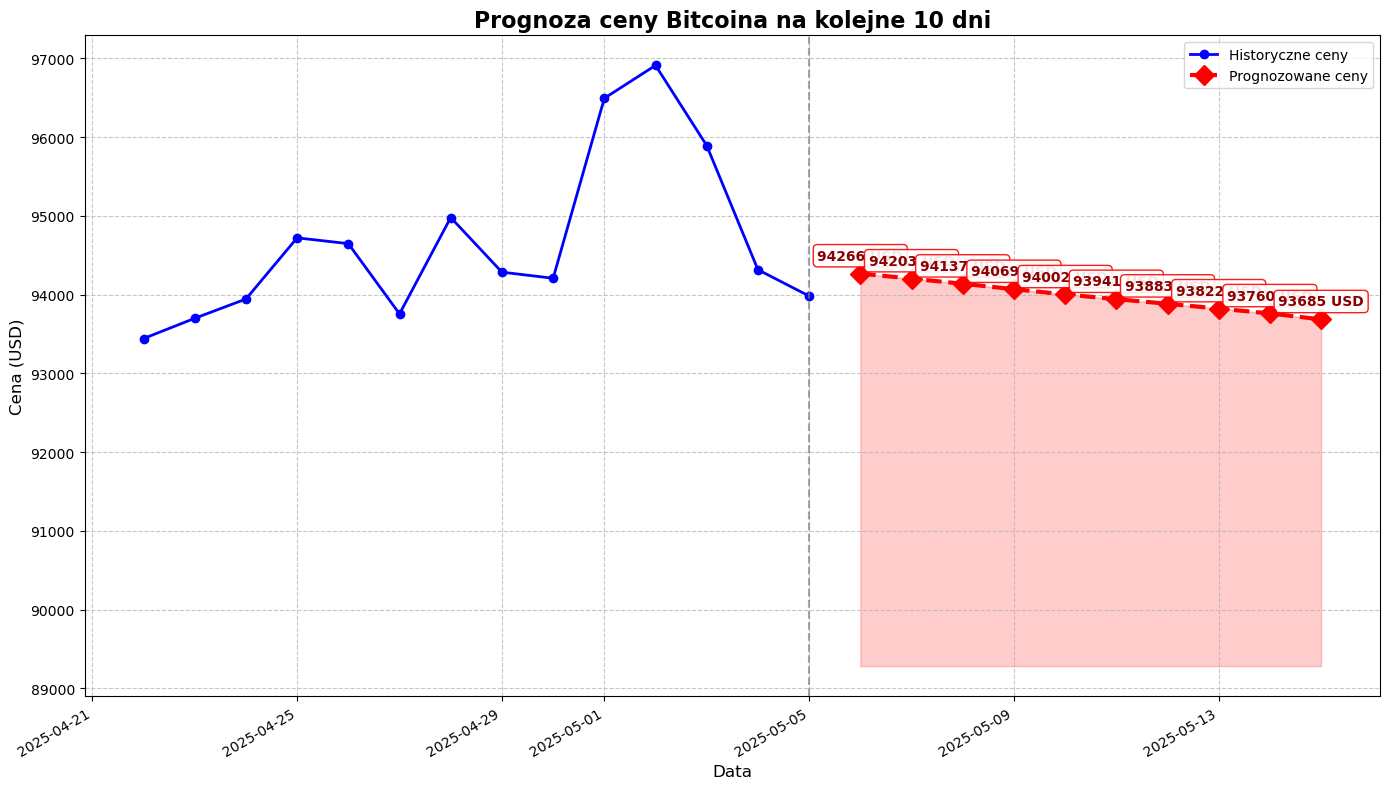

C:\Users\kubal\AppData\Local\Temp\ipykernel_26468\1886815002.py:90: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_known_price = float(data['Close'].iloc[-1])


In [ ]:
days_to_predict = 10

last_window = data['Close'].values[-window_size:].copy()
current_date = data.index[-1]

future_dates = []
future_prices = []

for i in range(days_to_predict):
    x_input = scaler.transform(last_window.reshape(-1, 1)).flatten()
    x_input = np.array(x_input).reshape(1, window_size, 1)
    
    price_scaled = model.predict(x_input, verbose=0)[0][0]
    predicted_price = scaler.inverse_transform([[price_scaled]])[0][0]
    
    current_date = current_date + pd.Timedelta(days=1)
    future_dates.append(current_date)
    future_prices.append(predicted_price)
    
    last_window = np.append(last_window[1:], predicted_price)

historical_dates = data.index[-window_size:].tolist()
historical_prices = data['Close'].values[-window_size:].tolist()

plt.figure(figsize=(14, 8))

plt.plot(historical_dates, historical_prices, 'b-', marker='o', linewidth=2, 
         markersize=6, label='Historyczne ceny')

plt.plot(future_dates, future_prices, 'r--', linewidth=3, marker='D', 
         markersize=10, label='Prognozowane ceny', zorder=3)

plt.axvline(x=historical_dates[-1], color='gray', linestyle='--', alpha=0.7)

last_historical_price = historical_prices[-1]
if isinstance(last_historical_price, list):
    last_historical_price = last_historical_price[0]
last_historical_price = float(last_historical_price)

first_prediction_price = float(future_prices[0])

min_price = min(last_historical_price, first_prediction_price) * 0.95
fill_bottom = np.full(len(future_dates), min_price)

future_prices_array = np.array(future_prices, dtype=float)

plt.fill_between(future_dates, fill_bottom, future_prices_array, alpha=0.2, color='red')

for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    plt.annotate(f'{int(price)} USD', 
                 xy=(date, price),
                 xytext=(0, 10),
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color='darkred',
                 ha='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.9))

plt.scatter(future_dates, future_prices, color='red', s=80, zorder=4)

plt.title('Prognoza ceny Bitcoina na kolejne 10 dni', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Cena (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.legend(loc='best')
plt.tight_layout()
plt.show()

last_known_price = float(data['Close'].iloc[-1])
future_price_final = float(future_prices[-1])
total_change_percent = (future_price_final - last_known_price) / last_known_price * 100

first_prediction = float(future_prices[0])
last_prediction = float(future_prices[-1])
prediction_change_percent = (last_prediction - first_prediction) / first_prediction * 100

Testujemy prognozę od daty: 2015-04-07
Używamy danych historycznych z poprzednich 14 dni


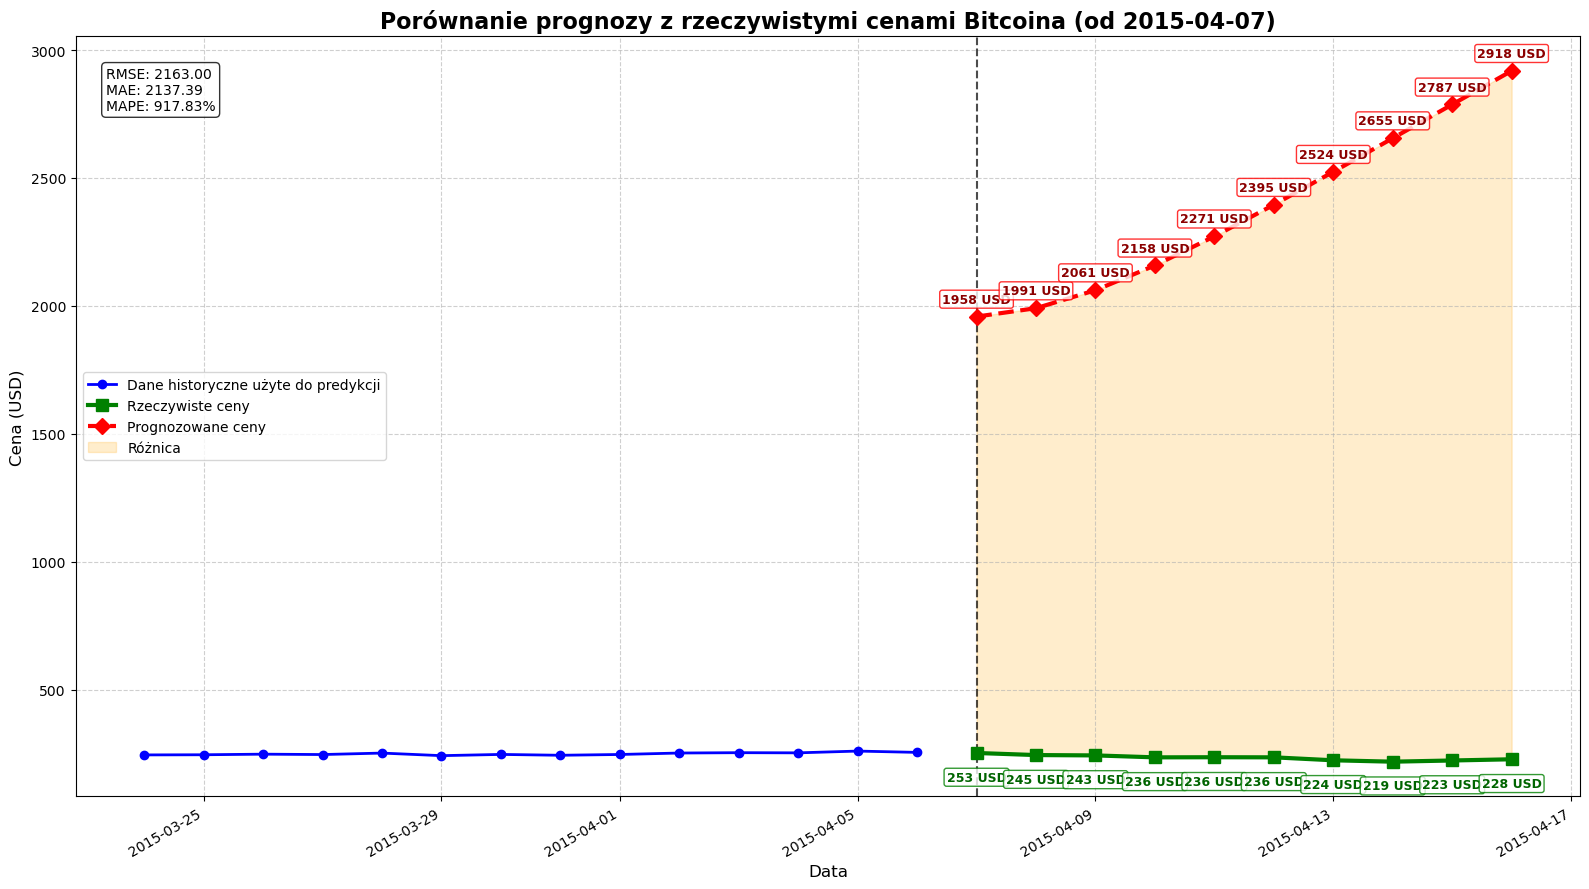


Tabela porównawcza prognoz z rzeczywistymi cenami:
Dzień 1: 2015-04-07 - Prognoza: 1958 USD, Rzeczywista: 253 USD, Różnica: 1705 USD (673.52%)
Dzień 2: 2015-04-08 - Prognoza: 1991 USD, Rzeczywista: 245 USD, Różnica: 1746 USD (712.63%)
Dzień 3: 2015-04-09 - Prognoza: 2061 USD, Rzeczywista: 243 USD, Różnica: 1817 USD (745.92%)
Dzień 4: 2015-04-10 - Prognoza: 2158 USD, Rzeczywista: 236 USD, Różnica: 1922 USD (814.19%)
Dzień 5: 2015-04-11 - Prognoza: 2271 USD, Rzeczywista: 236 USD, Różnica: 2035 USD (860.35%)
Dzień 6: 2015-04-12 - Prognoza: 2395 USD, Rzeczywista: 236 USD, Różnica: 2158 USD (914.24%)
Dzień 7: 2015-04-13 - Prognoza: 2524 USD, Rzeczywista: 224 USD, Różnica: 2299 USD (1023.85%)
Dzień 8: 2015-04-14 - Prognoza: 2655 USD, Rzeczywista: 219 USD, Różnica: 2436 USD (1111.56%)
Dzień 9: 2015-04-15 - Prognoza: 2787 USD, Rzeczywista: 223 USD, Różnica: 2563 USD (1145.18%)
Dzień 10: 2015-04-16 - Prognoza: 2918 USD, Rzeczywista: 228 USD, Różnica: 2689 USD (1176.82%)

Średni bezwzględny błą

{'mape': 917.8257789105235,
 'pred_change': 49.02384039991258,
 'actual_change': -9.719170290212316,
 'final_error_pct': 1176.8209610911322}

In [ ]:
def test_bitcoin_prediction(data, model, scaler, window_size, random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)
    
    test_period = 10 
    
    min_index = window_size + 20
    max_index = len(data) - test_period - 20
    past_date_index = np.random.randint(min_index, max_index)
    past_date = data.index[past_date_index]
    
    print(f"Testujemy prognozę od daty: {past_date.date()}")
    print(f"Używamy danych historycznych z poprzednich {window_size} dni")
    
    historical_window = data['Close'].values[past_date_index - window_size:past_date_index].copy()
    future_actual_prices = data['Close'].values[past_date_index:past_date_index + test_period]
    future_actual_dates = data.index[past_date_index:past_date_index + test_period]
    
    test_future_dates = []
    test_future_prices = []
    current_window = historical_window.copy()
    
    for i in range(test_period):
        x_input = scaler.transform(current_window.reshape(-1, 1)).flatten()
        x_input = np.array(x_input).reshape(1, window_size, 1)
        
        price_scaled = model.predict(x_input, verbose=0)[0][0]
        predicted_price = scaler.inverse_transform([[price_scaled]])[0][0]
        
        current_date = data.index[past_date_index + i]
        test_future_dates.append(current_date)
        test_future_prices.append(predicted_price)
        
        current_window = np.append(current_window[1:], predicted_price)
    
    test_future_prices = np.array(test_future_prices).flatten()
    future_actual_prices = np.array(future_actual_prices).flatten()
    
    plt.figure(figsize=(16, 9))
    
    historical_dates = data.index[past_date_index - window_size:past_date_index].tolist()
    historical_prices = data['Close'].values[past_date_index - window_size:past_date_index].tolist()
    plt.plot(historical_dates, historical_prices, 'b-', marker='o', linewidth=2, 
             markersize=6, label='Dane historyczne użyte do predykcji')
    
    plt.plot(future_actual_dates, future_actual_prices, 'g-', marker='s', linewidth=3, 
             markersize=8, label='Rzeczywiste ceny', zorder=4)
    
    plt.plot(test_future_dates, test_future_prices, 'r--', linewidth=3, marker='D', 
             markersize=8, label='Prognozowane ceny', zorder=3)
    
    plt.fill_between(test_future_dates, test_future_prices, future_actual_prices, 
                     color='orange', alpha=0.2, label='Różnica')
    
    for i, (date, pred, actual) in enumerate(zip(test_future_dates, test_future_prices, future_actual_prices)):
        plt.annotate(f'{int(pred)} USD', 
                     xy=(date, pred),
                     xytext=(0, 10),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold',
                     color='darkred',
                     ha='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.8))
        
        plt.annotate(f'{int(actual)} USD', 
                     xy=(date, actual),
                     xytext=(0, -20),
                     textcoords='offset points',
                     fontsize=9,
                     fontweight='bold',
                     color='darkgreen',
                     ha='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='green', alpha=0.8))
    
    plt.axvline(x=past_date, color='black', linestyle='--', alpha=0.7)
    
    plt.title(f'Porównanie prognozy z rzeczywistymi cenami Bitcoina (od {past_date.date()})', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Cena (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gcf().autofmt_xdate()
    plt.legend(loc='best')
    plt.tight_layout()
    
    mse = mean_squared_error(future_actual_prices, test_future_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(future_actual_prices, test_future_prices)
    
    mape = np.mean(np.abs((future_actual_prices - test_future_prices) / future_actual_prices)) * 100
    
    info_text = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%'
    plt.annotate(info_text, xy=(0.02, 0.96), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round', fc='white', ec='black', alpha=0.8),
                 fontsize=10, va='top')
    
    plt.show()
    
    print("\nTabela porównawcza prognoz z rzeczywistymi cenami:")
    for i, (date, pred, actual) in enumerate(zip(test_future_dates, test_future_prices, future_actual_prices)):
        diff = pred - actual
        diff_percent = (diff / actual) * 100
        print(f"Dzień {i+1}: {date.date()} - Prognoza: {int(pred)} USD, Rzeczywista: {int(actual)} USD, " +
              f"Różnica: {int(diff)} USD ({diff_percent:.2f}%)")
    
    final_diff = test_future_prices[-1] - future_actual_prices[-1]
    final_diff_percent = (final_diff / future_actual_prices[-1]) * 100
    
    pred_change = ((test_future_prices[-1] - test_future_prices[0]) / test_future_prices[0] * 100)
    actual_change = ((future_actual_prices[-1] - future_actual_prices[0]) / future_actual_prices[0] * 100)
    
    print(f"\nŚredni bezwzględny błąd procentowy (MAPE): {mape:.2f}%")
    print(f"Prognozowana zmiana po 10 dniach: {pred_change:.2f}%")
    print(f"Rzeczywista zmiana po 10 dniach: {actual_change:.2f}%")
    print(f"Błąd prognozy na 10. dzień: {final_diff_percent:.2f}%")
    
    return {
        'mape': mape,
        'pred_change': pred_change,
        'actual_change': actual_change,
        'final_error_pct': final_diff_percent
    }

test_bitcoin_prediction(data, model, scaler, window_size)